In [7]:
#!pip install beautifulsoup4
#!pip install requests
#!pip install tk
#!pip install pillow
#!pip install python-dotenv

In [5]:
import requests
import csv
import json
from bs4 import BeautifulSoup
import re
import math
import random
import tkinter
import turtle
import numpy as np
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.figure import Figure
from tkinter import messagebox
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv,dotenv_values


# Construcción del DataSet

## Inicialización y utilidades

In [7]:
load_dotenv()
config = dotenv_values("token.env")
bearer = config["bearer"]

file = 'dataSet.csv'
GLOBAL_RULES = []

if os.path.exists(file):
    with open(file) as file_csv:
        lines = csv.reader(file_csv)
        for row in lines:
            GLOBAL_RULES.append(row[1])

def add_system(file,system):
    if system['Rules'] not in GLOBAL_RULES: 
        with open(file, 'a',newline='') as f_csv:
            writer = csv.writer(f_csv)
            GLOBAL_RULES.append(system['Rules'])
            writer.writerow([system['Start'],str(system['Rules']),system['Angle'],system['Likes']])

## Extracción de tweets y los likes asociados 

In [8]:
def twitter_API(id):
    url = "https://api.twitter.com/labs/2/tweets/" + id + "?tweet.fields=public_metrics"
    r = requests.get(url,headers={'Authorization':'Bearer ' + bearer})
    return r.json()

In [9]:
#Extrae Tweets y devuelve el máximo de likes para ponderar los sistemas L 'bien conocidos'
def create_data_set(file):
    global_likes = []
    #Read IDs
    with open('tweets.txt') as f_txt:
        lines = f_txt.readlines()
        for id in lines:
            response = twitter_API(str(id).strip())
            print(response)
            dict = eval(response['data']["text"][:-24].replace("true","True").replace("false","False"))
            start = dict['start']
            rules = dict['rules']

            if 'a' in dict:
                angle = dict['a']
            else:
                angle = 'unknown'

            likes = response['data']["public_metrics"]["like_count"]
            
            global_likes.append(int(likes))
            
            system = {}
            system['Start'] = start
            system['Rules'] = rules
            system['Angle'] = angle
            system['Likes'] = likes
            add_system(file,system)
    return max(global_likes)

## Extracción de Sistemas-L con reglas conocidas

In [10]:
#Entrada: F > FXF | Salida: {'F':'FXF'}
def extract_rules(rules):
    rules_dict = dict()
    for rule in rules:
        if re.match("\w\s>",rule):
            fields = rule.split(">")
            rules_dict[fields[0].strip()] = fields[1].strip().replace("<","").replace(">","")
        else:
            fields = rule.split("->")
            rules_dict[fields[0].strip()] = fields[1].strip().replace("<","").replace(">","")
    return rules_dict

def extract_system(contents):
    rules = []
    start = ""
    angle = ""
    for content in contents:
        content = str(content).strip()
        if content.startswith('Axiom'):
            start = content.split(":")[1].strip()
        if content.startswith('axiom'):
            start = content.split("=")[1].strip()
        if content.startswith('Rule: '):
            rule = content.split(":")[1].strip()
            rules.append(rule)
        if re.match('\w\s>',content):
            rules.append(content.strip())
        if re.match('\w\s->',content):
            rules.append(content.strip())
        if content.startswith('Angle'):
            angle = content.split(":")[1].strip().replace('°','')
            if re.match('π/\d',angle):
                pi=math.pi
                angle = angle.replace('π','pi')
                angle = int(math.degrees(eval(angle)))
        if content.startswith('angle'):
            angle = content.split("=")[1].strip().replace('°','')
    return (start,rules,angle)

In [11]:
def find_all_p(s):
    result = []
    p_s = s.find_all("p")
    for p in p_s:
        if "axiom =" in p.text:
            result.append(",".join(p.stripped_strings).split(","))
    return result

In [12]:
def wellKnown_systems_scraping(file,url,likes):
    
    response = requests.get(url)
    s = BeautifulSoup(response.text,'lxml')

    table = s.find("table",attrs={"border":"1"})
    if table:
        trs = table.find_all("tr")
        for tr in trs:
            contents = tr.find_all("td")[1].contents

            start,rules,angle = extract_system(contents)

            rules_dict = extract_rules(rules)
            system = dict()
            system['Start'] = start
            system['Rules'] = rules_dict
            system['Angle'] = angle
            system['Likes'] = likes*2
            
            add_system(file,system)
    else:
        table = s.find_all("td",attrs={"valign":"top"})
        for t in table:
            if t.text.strip().startswith('axiom'):
                contents = t.contents
                
                start,rules,angle = extract_system(contents)
                
                rules_dict = extract_rules(rules)
                system = dict()
                system['Start'] = start
                system['Rules'] = rules_dict
                system['Angle'] = angle
                system['Likes'] = likes*2
                
                add_system(file,system)
        
        p_systems = find_all_p(s)
        for contents in p_systems:
            start,rules,angle = extract_system(contents)
            rules_dict = extract_rules(rules)
            system = dict()
            system['Start'] = start
            system['Rules'] = rules_dict
            system['Angle'] = angle
            system['Likes'] = likes*2
            
            add_system(file,system)


## Creación del data set con los tweets y los sistemas con reglas conocidas


In [13]:
likes = create_data_set(file)

urls = ["https://fedimser.github.io/l-systems.html","http://paulbourke.net/fractals/lsys/"]
for url in urls:
    wellKnown_systems_scraping(file,url,likes)
    

{'data': {'id': '1283238622028632065', 'public_metrics': {'retweet_count': 3, 'reply_count': 0, 'like_count': 6, 'quote_count': 0}, 'text': '{"start":"XYXF","rules":{"F":"F++FX+","X":"-F+[F]FAFA","A":"+YFEF-E","E":"YFEAY","Y":"[-Y]"},"a":45,"iter":4} https://t.co/1gMpfzDZ9p'}}
{'data': {'id': '1283223522605535232', 'public_metrics': {'retweet_count': 3, 'reply_count': 0, 'like_count': 3, 'quote_count': 0}, 'text': '{"start":"FSF","rules":{"F":"SCF+B","M":"+SCC","C":"[]FC","S":"[]+","B":"SB+M++FBF"},"a":188,"iter":4} https://t.co/PSss8DNfPx'}}
{'data': {'id': '1283208424323350528', 'public_metrics': {'retweet_count': 4, 'reply_count': 0, 'like_count': 7, 'quote_count': 1}, 'text': '{"start":"NFCH","rules":{"F":"[]YHFHFF-","N":"CHC","H":"ECFFNE","Y":"N[E]"},"a":36,"iter":7} https://t.co/LMlrZqXMn3'}}
{'data': {'id': '1283193322295554048', 'public_metrics': {'retweet_count': 5, 'reply_count': 0, 'like_count': 9, 'quote_count': 0}, 'text': '{"start":"F","rules":{"F":"[FF-FF--]F","L":"[+]"}

{'data': {'id': '1282589341097680900', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 2, 'quote_count': 0}, 'text': '{"start":"WX","rules":{"F":"[-]+W-UU","X":"[FF]","W":"X+X--","U":"[[W]]"},"a":45,"iter":5} https://t.co/Jigya5H2QC'}}
{'data': {'id': '1282574240714092547', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 7, 'quote_count': 0}, 'text': '{"start":"E","rules":{"F":"[H]+HFF","H":"[-HF-F]-E","N":"-H+HEF","E":"FF+"},"a":36,"iter":4} https://t.co/raIP3hSdoI'}}
{'data': {'id': '1282559232131207168', 'public_metrics': {'retweet_count': 8, 'reply_count': 3, 'like_count': 28, 'quote_count': 1}, 'text': '{"start":"FFMF","rules":{"F":"F","M":"M+F-M-F"},"a":36,"iter":16} https://t.co/2y2JjOLStM'}}
{'data': {'id': '1282544041473609729', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 1, 'quote_count': 0}, 'text': '{"start":"FFF","rules":{"F":"F+F+-J","J":"FF"},"a":90,"iter":5} https://t.co/ZWNeTrLVlD'}}
{'data': {'id

{'data': {'id': '1282000460417650688', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 1, 'quote_count': 0}, 'text': '{"start":"U","rules":{"F":"AJA","Q":"JU","U":"+QAQ+B","J":"FA[-]A","A":"B","B":"F"},"a":45,"iter":6} https://t.co/SeDNL23Fwf'}}
{'data': {'id': '1281985365734121474', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 1, 'quote_count': 0}, 'text': '{"start":"KFFK","rules":{"F":"[[]-FF-F]+"},"a":60,"iter":4} https://t.co/tUJa3L4bCP'}}
{'data': {'id': '1281970264494882817', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 2, 'quote_count': 0}, 'text': '{"start":"FWWF","rules":{"W":"[F]W+F-"},"a":76,"iter":4} https://t.co/dQSXNOLNv2'}}
{'data': {'id': '1281955162701959168', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 1, 'quote_count': 0}, 'text': '{"start":"CY","rules":{"F":"[F-]CY-","Y":"E[FE]","C":"[]F-FFE-+"},"a":297,"iter":7} https://t.co/mDkWDrqVLp'}}
{'data': {'id': '128194006

{'data': {'id': '1281441779108069377', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}, 'text': '{"start":"LHH","rules":{"F":"[L-[[]]H]","X":"[[]LL[]H]","L":"[]UF-XLHUU","U":"U"},"a":90,"iter":6} https://t.co/Onusl8ivQa'}}
{'data': {'id': '1281426682289643521', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}, 'text': '{"start":"V","rules":{"F":"RRVFU","R":"[[F]V]F-FFV","V":"USFFS","U":"[]S","S":"[F-[[]]F]+VU","P":"[[]]RF-FSUV"}} https://t.co/HikKrORQku'}}
{'data': {'id': '1281411595516559362', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 3, 'quote_count': 0}, 'text': '{"start":"FF","rules":{"F":"R[--+RF]FF","T":"[]","R":"[[F-][]]F+FF"},"a":45,"iter":7} https://t.co/Yr36OrxYeA'}}
{'data': {'id': '1281381384087408640', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}, 'text': '{"start":"IIFF","rules":{"F":"-+IIFIF+F","I":"[-]F++"},"a

{'data': {'id': '1280837800451964929', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}, 'text': '{"start":"QSFM","rules":{"F":"[]+","M":"ZFFFFF","N":"-","Z":"-NFMF","S":"F","Q":"QFM"},"a":70,"iter":4} https://t.co/TsRlbeGmlT'}}
{'data': {'id': '1280822706225549317', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 2, 'quote_count': 0}, 'text': '{"start":"AG","rules":{"F":"[EA[-+]FF]","X":"[G]F-A","E":"[XX][XF-FF]","G":"GGX","A":"[FA-F]GEG+"},"a":60,"iter":7} https://t.co/nqSn9McgBm'}}
{'data': {'id': '1280807598497779713', 'public_metrics': {'retweet_count': 1, 'reply_count': 0, 'like_count': 4, 'quote_count': 0}, 'text': '{"start":"FS","rules":{"F":"[[+]]IF+FI","I":"--"},"a":44,"iter":5} https://t.co/oAdGaZngPe'}}
{'data': {'id': '1280792501398335489', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}, 'text': '{"start":"SV","rules":{"F":"FFF","X":"SFN-","G":"V","V":"XG+GFNNFF",

{'data': {'id': '1280248922783354880', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}, 'text': '{"start":"VV","rules":{"F":"[]","V":"U[V+W]-FV","U":"UUV","W":"U-VWWWFF"},"a":45,"iter":7} https://t.co/R1ROzDjTnJ'}}
{'data': {'id': '1280233818763345920', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 6, 'quote_count': 0}, 'text': '{"start":"F","rules":{"F":"FF+[F]","E":"FFA+-F","R":"-EFA+-","A":"Z"},"a":333,"iter":6} https://t.co/UNx89abE7m'}}
{'data': {'id': '1280203619153768450', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 2, 'quote_count': 0}, 'text': '{"start":"EC","rules":{"F":"FZZ","E":"--KK","K":"F-KCC[F]FK","C":"C"},"a":90,"iter":6} https://t.co/tDRFNWLLpB'}}
{'data': {'id': '1280188522230542336', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 2, 'quote_count': 0}, 'text': '{"start":"CZO","rules":{"F":"FO+Z-+F","O":"[[[]C]]OZ","Z":"Z","N":"FF++","C":"FNNC"},"a":

{'data': {'id': '1279554343855783938', 'public_metrics': {'retweet_count': 1, 'reply_count': 0, 'like_count': 5, 'quote_count': 0}, 'text': '{"start":"FWII","rules":{"F":"IIIIW-IF","I":"F","W":"[[]FWF]"},"a":264,"iter":6} https://t.co/c0gM4pSDcF'}}
{'data': {'id': '1279524143180902400', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}, 'text': '{"start":"FX","rules":{"F":"MFXF-FF","X":"[]++MF+MFF","Y":"Y[F]MX-F","M":"FF"},"a":60,"iter":4} https://t.co/FwlZHYWKr1'}}
{'data': {'id': '1279509044202369029', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}, 'text': '{"start":"I","rules":{"F":"F-F-+FMF","I":"[+]IF","M":"[][[F]M]MM+-"},"a":36,"iter":5} https://t.co/RcVmY1f3Qy'}}
{'data': {'id': '1279493945551024129', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}, 'text': '{"start":"ZR","rules":{"K":"RZ[+-+E[F]]","T":"--[K+TRF]K","E":"Z[T+ER]","R":"FF+FF-","Z":"KK

{'data': {'id': '1278965465767751686', 'public_metrics': {'retweet_count': 1, 'reply_count': 0, 'like_count': 2, 'quote_count': 0}, 'text': '{"start":"GFFF","rules":{"F":"G[G]-G-","G":"[[F]FF]G"},"a":33,"iter":6} https://t.co/UijfTKCs6T'}}
{'data': {'id': '1278950393221767168', 'public_metrics': {'retweet_count': 2, 'reply_count': 0, 'like_count': 4, 'quote_count': 0}, 'text': '{"start":"LE","rules":{"F":"LLL[FG]L","E":"ELFF+-","G":"LF[FFL-]F","L":"FF[G]G+"},"a":45,"iter":7} https://t.co/DZwBKJAoF3'}}
{'data': {'id': '1278935261745778688', 'public_metrics': {'retweet_count': 1, 'reply_count': 0, 'like_count': 1, 'quote_count': 0}, 'text': '{"start":"IFF","rules":{"F":"H-I+Y","I":"[I]FF--I+F","J":"+Y","Y":"FY","H":"YIJ+FJY"},"a":60,"iter":5} https://t.co/OKp8eXw9ib'}}
{'data': {'id': '1278920164302417920', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}, 'text': '{"start":"PFU","rules":{"F":"FX","G":"-PF-[UG]U","P":"XF","U":"[FUG]"},"a":246,"i

{'data': {'id': '1278391682933723137', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}, 'text': '{"start":"XGNF","rules":{"F":"[XF]XN","X":"-NX","G":"XXGWGXF-","W":"XXWFWFGWX","N":"+F+NNW"},"a":60,"iter":4} https://t.co/01IyYnojxt'}}
{'data': {'id': '1278361484423081984', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 7, 'quote_count': 0}, 'text': '{"start":"FFF","rules":{"F":"F[FYF]-+","H":"+YD","D":"[H[Q]D]ZZFF","Y":"[-D]+","Q":"ZFQDF+Q","Z":"-FFQF"},"a":36} https://t.co/6iLoDLcAEW'}}
{'data': {'id': '1278346383284531201', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}, 'text': '{"start":"WWUW","rules":{"F":"W","U":"[]","W":"[FW]+"},"a":60,"iter":16} https://t.co/3xCiUVCpB2'}}
{'data': {'id': '1278331281709789184', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}, 'text': '{"start":"J","rules":{"F":"YA+-FYV-","A":"[-]HAHF","V":"HA

{'data': {'id': '1277848102687215617', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 2, 'quote_count': 0}, 'text': '{"start":"TO","rules":{"F":"SFA","S":"-H+++-A-+","T":"F+H[F]FFF","O":"[H]FFO","H":"+A","A":"-[F-]F+A"},"a":90} https://t.co/8cBgvT1YAX'}}
{'data': {'id': '1277832998855958530', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}, 'text': '{"start":"YMM","rules":{"F":"F","M":"-++[F]M+","Y":"FYFMFMYF"},"a":90,"iter":7} https://t.co/atL0bCg5Hn'}}
{'data': {'id': '1277817899806162949', 'public_metrics': {'retweet_count': 1, 'reply_count': 0, 'like_count': 1, 'quote_count': 1}, 'text': '{"start":"WK","rules":{"F":"-","U":"NKCU--","C":"[CK]F","N":"-","W":"[]FFK-N","K":"[U]KFWN"},"a":36,"iter":6} https://t.co/wNBiE8yBPH'}}
{'data': {'id': '1277802801851011077', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 2, 'quote_count': 0}, 'text': '{"start":"DI","rules":{"F":"[]J[D-G]J","D":"[[G+]J]","

{'data': {'id': '1277289452910469120', 'public_metrics': {'retweet_count': 1, 'reply_count': 0, 'like_count': 5, 'quote_count': 0}, 'text': '{"start":"YWRF","rules":{"F":"YFR+H[-]Y","Y":"+F+W+FFR-","U":"[R]","W":"[H]RHFW+H","R":"[]Y","H":"H-FH"},"a":90} https://t.co/EWZAU368DL'}}
{'data': {'id': '1277274320209768448', 'public_metrics': {'retweet_count': 1, 'reply_count': 0, 'like_count': 2, 'quote_count': 0}, 'text': '{"start":"CQCJ","rules":{"F":"--FFJX-FF","J":"[[-]]","Q":"CXFJF","C":"[J]F+JC","X":"CQX-"},"a":36,"iter":6} https://t.co/ajPcbIgAul'}}
{'data': {'id': '1277259252239757312', 'public_metrics': {'retweet_count': 1, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}, 'text': '{"start":"B","rules":{"F":"FRRFFBFHH","H":"B[BR+A]F[H]","A":"FRJH","B":"RB-F","J":"BAFR[B]+B","R":"+R"},"a":34} https://t.co/TBBSKaWg1S'}}
{'data': {'id': '1277244120193306624', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 1, 'quote_count': 0}, 'text': '{"start":"T","rules":{

{'data': {'id': '1276760939048493056', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 1, 'quote_count': 0}, 'text': '{"start":"NN","rules":{"F":"E[+]SE+FEX","X":"+","E":"+F++-NF","S":"[]+S-NNN","N":"H+SHFEF","H":"FF"},"a":60,"iter":7} https://t.co/i361CAbVB4'}}
{'data': {'id': '1276745839822557184', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 1, 'quote_count': 0}, 'text': '{"start":"FRFF","rules":{"F":"[]FFFF+","R":"[]R+F"},"a":45,"iter":6} https://t.co/qgS66wm66e'}}
{'data': {'id': '1276730738885312513', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 1, 'quote_count': 0}, 'text': '{"start":"MXE","rules":{"F":"[+U]","U":"FEX","J":"X[JU]EJ","M":"U[JF]M+F+","E":"M-FUF","X":"[]UFXEEF"},"a":4} https://t.co/foMZ70hTbM'}}
{'data': {'id': '1276700539145744384', 'public_metrics': {'retweet_count': 2, 'reply_count': 1, 'like_count': 2, 'quote_count': 0}, 'text': '{"start":"Q","rules":{"Q":"[]QF+Q+"},"a":60,"iter":4} http

{'data': {'id': '1276187156369661952', 'public_metrics': {'retweet_count': 1, 'reply_count': 0, 'like_count': 1, 'quote_count': 0}, 'text': '{"start":"FFFS","rules":{"F":"FS-","V":"-FF","S":"FV"},"a":90,"iter":4} https://t.co/mvcKbjhZre'}}
{'data': {'id': '1276172059479957504', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}, 'text': '{"start":"FW","rules":{"F":"[W]++-FZWF","Z":"WWF-","W":"[F]FZW+FFZ"},"a":90,"iter":6} https://t.co/15CVKg83mf'}}
{'data': {'id': '1276156956584091653', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}, 'text': '{"start":"FK","rules":{"F":"U-T","K":"J","J":"JF","P":"T","U":"-P","T":"PPTJ"},"a":36,"iter":7} https://t.co/vxbNdHZF2a'}}
{'data': {'id': '1276141857882308614', 'public_metrics': {'retweet_count': 1, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}, 'text': '{"start":"FFF","rules":{"F":"FH[+[]]","H":"FH--"},"a":90,"iter":7} https://t.co/PWzlBROyJe'}}
{'data'

{'data': {'id': '1275673774210367489', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 2, 'quote_count': 0}, 'text': '{"start":"ZZM","rules":{"Z":"[[[][F+Z]FF]]","M":"[[]]F"},"a":90,"iter":4} https://t.co/GNgX9dtDsx'}}
{'data': {'id': '1275658684002193408', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 6, 'quote_count': 0}, 'text': '{"start":"FFC","rules":{"F":"[]+FF+FF","C":"+"},"a":94,"iter":6} https://t.co/21QzDpA4Fo'}}
{'data': {'id': '1275643580086960133', 'public_metrics': {'retweet_count': 4, 'reply_count': 1, 'like_count': 21, 'quote_count': 0}, 'text': '{"start":"JSCC","rules":{"F":"FS--CSFF","C":"[SCFF[]F]","G":"+--+GJ","S":"-","J":"CCFSFFF+"},"a":90,"iter":7} https://t.co/BnmGhCsJk4'}}
{'data': {'id': '1275628473034268672', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 4, 'quote_count': 0}, 'text': '{"start":"FFR","rules":{"F":"F-","R":"F--F+RFF"},"a":60,"iter":16} https://t.co/3ymkSzuSPu'}}
{'data': {'

{'data': {'id': '1275115092091133957', 'public_metrics': {'retweet_count': 1, 'reply_count': 0, 'like_count': 3, 'quote_count': 0}, 'text': '{"start":"RCFB","rules":{"F":"+RF","D":"CF+D-","G":"FF-C+F","B":"C+CFF","C":"GG","R":"DD-FC+"},"a":90,"iter":7} https://t.co/VVDrsqr6y5'}}
{'data': {'id': '1275099990981926921', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 2, 'quote_count': 0}, 'text': '{"start":"FFNJ","rules":{"F":"[Y][P]NY-F","J":"-","P":"J-","N":"F+N+NYF"},"a":60,"iter":7} https://t.co/ALVqyw6kVW'}}
{'data': {'id': '1275084893450498048', 'public_metrics': {'retweet_count': 1, 'reply_count': 0, 'like_count': 1, 'quote_count': 0}, 'text': '{"start":"YCMY","rules":{"F":"TFF[CM]","Y":"TFFFM","T":"E[FF+M]C+","C":"FCFYE-","E":"-+[F]T"},"a":60,"iter":4} https://t.co/H4mCmVMxZ3'}}
{'data': {'id': '1275069799987466241', 'public_metrics': {'retweet_count': 3, 'reply_count': 0, 'like_count': 3, 'quote_count': 0}, 'text': '{"start":"F","rules":{"F":"S[FSSFFFF]","S

{'data': {'id': '1274571510066188288', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 2, 'quote_count': 0}, 'text': '{"start":"I","rules":{"F":"[[G]]","G":"[[F]]+FGU","U":"FFFUFG","I":"[[[]]UG]I"},"a":45,"iter":5} https://t.co/MVAbPvMsfK'}}
{'data': {'id': '1274556413113585664', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 2, 'quote_count': 0}, 'text': '{"start":"RA","rules":{"F":"[F]AA","T":"T[T]N","N":"T[T]FF+F","R":"[]","A":"NTT"},"a":287,"iter":7} https://t.co/d1LHozhtLx'}}
{'data': {'id': '1274541311194886144', 'public_metrics': {'retweet_count': 0, 'reply_count': 1, 'like_count': 2, 'quote_count': 0}, 'text': '{"start":"IFDX","rules":{"D":"D[F]","I":"X+DIF","X":"DI-XDF"},"a":25,"iter":4} https://t.co/L2oFrR2Qx0'}}
{'data': {'id': '1274526210739978240', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}, 'text': '{"start":"VFFF","rules":{"F":"[]AFF-","A":"[]F","V":"[+[-F]AV]+"},"a":45,"iter"

{'data': {'id': '1273952431022342144', 'public_metrics': {'retweet_count': 1, 'reply_count': 0, 'like_count': 2, 'quote_count': 0}, 'text': '{"start":"NK","rules":{"F":"+FN-FNKF+","C":"FF++","K":"NK+F+N-F+","N":"N"},"a":175,"iter":5} https://t.co/XokLFkfjO3'}}
{'data': {'id': '1273937331951558656', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}, 'text': '{"start":"HH","rules":{"H":"[+-HF]+F"},"a":36,"iter":5} https://t.co/ERpePuY46y'}}
{'data': {'id': '1273922539350183938', 'public_metrics': {'retweet_count': 2, 'reply_count': 0, 'like_count': 8, 'quote_count': 0}, 'text': '{"start":"PFF","rules":{"F":"[]--FF+","P":"F--+"},"a":60,"iter":16} https://t.co/4MTwc5ijn0'}}
{'data': {'id': '1273907131620577280', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 1, 'quote_count': 0}, 'text': '{"start":"KUUF","rules":{"F":"N--UKNR","L":"N+-N++","R":"LLFF+LK","K":"+F[U]+U-R","U":"[]L+L","N":"+[N]LF"},"a":36} https://t.co/ZRuxWxZy3

{'data': {'id': '1273363550702952450', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}, 'text': '{"start":"GN","rules":{"F":"IH[-GF]GFH","A":"IFHFHF","H":"HHFIA-","I":"[G[N]FF]","N":"+-F++IFN","G":"A"},"a":90} https://t.co/3Jxg6HrvmL'}}
{'data': {'id': '1273348452521349120', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}, 'text': '{"start":"S","rules":{"F":"FSS+++FS","S":"+[S[[F]-+]F]","D":"[]++"},"a":45,"iter":5} https://t.co/keJLOny31u'}}
{'data': {'id': '1273333353039581184', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}, 'text': '{"start":"ZPFP","rules":{"F":"[[]P]F+","Z":"FZFZF+P","P":"[F+]+FVPZ+","V":"+[P]+VFZ"},"a":60,"iter":6} https://t.co/4xvImQERGB'}}
{'data': {'id': '1273318253968818177', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}, 'text': '{"start":"B","rules":{"F":"+V[VF]B+F","B":"BF+++F","V"

{'data': {'id': '1272804868739133440', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 1, 'quote_count': 0}, 'text': '{"start":"FFUU","rules":{"F":"F+[[F-+-]]F","U":"FFFFFUFU+"},"a":60,"iter":5} https://t.co/Ad62CskAAT'}}
{'data': {'id': '1272789771526393856', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}, 'text': '{"start":"FHF","rules":{"F":"LFFQ-","H":"[]FO[FHQ]","Q":"[[]-F]","O":"Q","L":"H"},"a":60,"iter":5} https://t.co/dgNF4LwKuK'}}
{'data': {'id': '1272774672375922693', 'public_metrics': {'retweet_count': 1, 'reply_count': 0, 'like_count': 3, 'quote_count': 0}, 'text': '{"start":"FCCL","rules":{"F":"W+WL","W":"[[FFF]F]+","C":"C+F","L":"WC"},"a":38,"iter":6} https://t.co/Bs0VzAAuCj'}}
{'data': {'id': '1272729372051468288', 'public_metrics': {'retweet_count': 0, 'reply_count': 1, 'like_count': 2, 'quote_count': 0}, 'text': '{"start":"J","rules":{"F":"NPF","P":"W[[P]]N","N":"JNKN","K":"-PKP+F","W":"-N","J":"FNJNKP

{'data': {'id': '1272261286135382017', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 1, 'quote_count': 0}, 'text': '{"start":"FRPG","rules":{"F":"[R-DG]D+D","G":"R[F]","D":"F+PRR--","P":"+","R":"GFDPDDP+"},"a":36,"iter":7} https://t.co/X2YWZ1QKoi'}}
{'data': {'id': '1272246199953719296', 'public_metrics': {'retweet_count': 1, 'reply_count': 0, 'like_count': 2, 'quote_count': 0}, 'text': '{"start":"RRRR","rules":{"F":"[FFF+]-","D":"[R]R+F[F]","R":"R-FFFR"},"a":36,"iter":7} https://t.co/s6KG4Be1Y1'}}
{'data': {'id': '1272231086907510784', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}, 'text': '{"start":"RTFF","rules":{"F":"FFF-","T":"FFFF-GGR","R":"GRRFR","G":"[R]T"},"a":45,"iter":4} https://t.co/dwWekuw2tX'}}
{'data': {'id': '1272215988210040834', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 1, 'quote_count': 0}, 'text': '{"start":"C","rules":{"F":"QWW","C":"WFWCW","Q":"CFQ","W":"+F"},"a":36

{'data': {'id': '1271717706643894272', 'public_metrics': {'retweet_count': 2, 'reply_count': 1, 'like_count': 10, 'quote_count': 0}, 'text': '{"start":"FWU","rules":{"F":"U+--U","I":"WF-FUFF","W":"[I]","U":"F-[M]F-F-F","M":"F"},"a":217,"iter":6} https://t.co/8Y0gJ8UNY7'}}
{'data': {'id': '1271702605262024704', 'public_metrics': {'retweet_count': 2, 'reply_count': 0, 'like_count': 3, 'quote_count': 0}, 'text': '{"start":"KFF","rules":{"F":"[FF]+[KF+]+","K":"FK[F+]F"},"a":36,"iter":4} https://t.co/WDEUt3njED'}}
{'data': {'id': '1271672407493767169', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}, 'text': '{"start":"BFI","rules":{"F":"-MX","M":"[[F]]-B","X":"-F[I]F","K":"X[F+]B-F","I":"F-X-F+I"},"a":90,"iter":5} https://t.co/drKlvgDDo3'}}
{'data': {'id': '1271657308569743360', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}, 'text': '{"start":"ZUZ","rules":{"F":"[-]F","U":"F[[[FU]]]ZAY","A":"AZYY+Y++F

{'data': {'id': '1271113726054154240', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}, 'text': '{"start":"ZZ","rules":{"F":"-[[-[]]-F]","Z":"[ZY]-ZFYFZ","Y":"[]ZF"},"a":36,"iter":5} https://t.co/RQq749w9Tf'}}
{'data': {'id': '1271098626220060672', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}, 'text': '{"start":"RWF","rules":{"F":"[F]WVFCH+","R":"VC","H":"HC","V":"+-","W":"RWFR","C":"W-"},"a":74,"iter":5} https://t.co/T3Pq7ddNTS'}}
{'data': {'id': '1271083525827997696', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}, 'text': '{"start":"PF","rules":{"F":"P","P":"[FP-[P]]F"},"a":36,"iter":5} https://t.co/y8y3QdmoCF'}}
{'data': {'id': '1271068428401381377', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 2, 'quote_count': 0}, 'text': '{"start":"U","rules":{"F":"+HFUF","H":"[]F+UF","U":"FH-"},"a":70,"iter":7} https://t.co/RlS3l4tPep'

{'data': {'id': '1270524846116450304', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}, 'text': '{"start":"F","rules":{"F":"YF+XFN","N":"[]F","Y":"[X]+-+YX","X":"+YX"},"a":42,"iter":5} https://t.co/M8y9iaGzBa'}}
{'data': {'id': '1270509743665115136', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 3, 'quote_count': 0}, 'text': '{"start":"F","rules":{"F":"M[M]HM-M","H":"F[F[H]]+","M":"[]F"},"a":45,"iter":7} https://t.co/KciDmY5qPd'}}
{'data': {'id': '1270494646456602624', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}, 'text': '{"start":"RRFF","rules":{"F":"R[F]++","X":"R-[R+X]","R":"F"},"a":36,"iter":5} https://t.co/lIqLlBM38u'}}
{'data': {'id': '1270479547465519106', 'public_metrics': {'retweet_count': 4, 'reply_count': 0, 'like_count': 9, 'quote_count': 0}, 'text': '{"start":"UUUB","rules":{"F":"[Z-]+FZ","U":"B+F[[+F]FF]","B":"ZF","Z":"U--U"},"a":36,"iter":7} https://t.co/u

{'data': {'id': '1269935964341678080', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 2, 'quote_count': 0}, 'text': '{"start":"MFFM","rules":{"F":"-F","M":"--+M+F--"},"a":60,"iter":6} https://t.co/HyG2ItBlYL'}}
{'data': {'id': '1269920864725696514', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}, 'text': '{"start":"ZE","rules":{"F":"Z++","E":"+","Z":"-[ZF[]]FZ"},"a":198,"iter":5} https://t.co/ivp9ZMTLji'}}
{'data': {'id': '1269905766565031937', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}, 'text': '{"start":"VVFV","rules":{"F":"[]+F","V":"+[V][W]","W":"FV[-]+F+"},"a":148,"iter":4} https://t.co/r4yUGdGAAx'}}
{'data': {'id': '1269890666420527112', 'public_metrics': {'retweet_count': 1, 'reply_count': 0, 'like_count': 2, 'quote_count': 0}, 'text': '{"start":"BBFF","rules":{"F":"H-V","B":"F[F[FV]VF]","H":"FFF","V":"[HB]F-"},"a":90,"iter":7} https://t.co/gdKESqwafY'}}
{'data':

{'data': {'id': '1269316885562093568', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 3, 'quote_count': 0}, 'text': '{"start":"AA","rules":{"A":"A[+[]]F+F"},"a":60,"iter":7} https://t.co/wh9bHlzLBK'}}
{'data': {'id': '1269301786289958912', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 2, 'quote_count': 0}, 'text': '{"start":"O","rules":{"F":"B+PBOO","B":"FFF-","P":"[O[]]FQUFQ","O":"+PFP+-F","Q":"F+F-F[BF]B","U":"U"},"a":90} https://t.co/5WvVRJ8afy'}}
{'data': {'id': '1269286687626063873', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 7, 'quote_count': 0}, 'text': '{"start":"F","rules":{"F":"+E+BF","B":"F-+","Q":"E+EBE-","C":"FF","E":"BCC-F-"},"a":60,"iter":7} https://t.co/E9A9TK4Qvq'}}
{'data': {'id': '1269271587208835074', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 1, 'quote_count': 0}, 'text': '{"start":"F","rules":{"F":"--FO","O":"OOF+-+[+]O"},"a":51,"iter":6} https://t.co/GnubZGvRi

{'data': {'id': '900609433075691521', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}, 'text': '{"start":"FF","rules":{"F":"[]-+-FY","Y":"[[[+]][]F]+"},"a":90,"iter":5} https://t.co/mvLoyb5kqH'}}
{'data': {'id': '900602158223167488', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}, 'text': '{"start":"DDYF","rules":{"F":"DF[WDW]-","Y":"[Y]YYD","W":"F"},"a":36,"iter":4} https://t.co/NCkc2Q0UmM'}}
{'data': {'id': '900594417945522180', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}, 'text': '{"start":"FWU","rules":{"M":"[WW]F","S":"FW","U":"UM","W":"[U]FU","A":"U"},"a":36,"iter":7,"wiggly":true} https://t.co/SqjEg4MjXE'}}
{'data': {'id': '900586787067875329', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}, 'text': '{"start":"BABB","rules":{"F":"U-T","U":"FBF","B":"TUF+U","A":"[B+F]-+BFB"},"a":60,"iter":4} https://t

{'data': {'id': '900368008702345218', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}, 'text': '{"start":"FRF","rules":{"F":"[]+FGF+G","J":"R-","R":"[]GM-G[NJ]","N":"MMFNFF-G","M":"NR[F]"},"a":60,"iter":4} https://t.co/IQgqZwFlfc'}}
{'data': {'id': '900360316072206336', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}, 'text': '{"start":"VNF","rules":{"F":"J","N":"-ZZZFZ","J":"VJWFFV","Z":"[-F]Z","W":"[NZN+]N-F+","V":"FNWJFFZZ"},"a":36} https://t.co/ymi2SH9AvF'}}
{'data': {'id': '900352784595386368', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}, 'text': '{"start":"FO","rules":{"F":"-FFO","O":"MF"},"a":36,"iter":4,"wiggly":true} https://t.co/VjT351PSB0'}}
{'data': {'id': '900345254368378880', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}, 'text': '{"start":"F","rules":{"F":"F+FF","I":"+F"},"a":90,"iter":4} htt

{'data': {'id': '900127662261358593', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}, 'text': '{"start":"KB","rules":{"F":"F[F]","Z":"N[KKZH]F","K":"BK","N":"H[[FB]][F]","H":"-H-BFBZK","B":"FZ"},"a":90,"iter":4} https://t.co/bAs1qkz5Rh'}}
{'data': {'id': '900126225229918208', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}, 'text': '{"start":"FPT","rules":{"F":"[]+FF-+-","T":"FPFF","P":"P+T-"},"a":90,"iter":5} https://t.co/F3lZUEannv'}}
{'data': {'id': '900118717522223105', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}, 'text': '{"start":"F","rules":{"F":"+[D++F]F","D":"F[D]+"},"a":90,"iter":4,"wiggly":true} https://t.co/oHlY9NZ9gk'}}
{'data': {'id': '900111171558232064', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}, 'text': '{"start":"FFNS","rules":{"F":"[]++","N":"SNF+F","S":"NNFN"},"a":36,"iter":5} https

## Generación de sistemas L

In [14]:
def generate_random_string(min,max,charSet):
    length = random.randint(min,max)
    string = ''
    for i in range(length):
        char = charSet[random.randint(0,len(charSet) - 1)]
        if char == ']':
            if len(string) == 0:
                index = 0
                string = string[0:index] + '[' + string[index:]
            else:
                index = random.randint(0,len(string) - 1)
                string = string[0:index] + '[' + string[index:]
        string += char
    return string
    
def generate():
    l_system = []
    charSet = ['F']
    alphabet = list('ABCDEGHIJKLMNOPQRSTUVWXYZ')
    controlCharSet = ['F', '+', '-', ']']
    angles = [36, 45, 60, 90, random.randint(0,359), random.randint(0,359)]
    iters = [4, 5, 6]
    extraSymbols = random.randint(1,4)
    
    for i in range(extraSymbols):
        index = random.randint(0,len(alphabet) - 1)
        charSet.append(alphabet[index])
        alphabet.pop(index)
    
    start = generate_random_string(1,5,charSet)
    
    rules = {}
    for char in charSet:
        rule = generate_random_string(0,10,charSet + controlCharSet)
        rules[char] = rule
        
    angle = angles[random.randint(0,len(angles) - 1)]
    iter = iters[random.randint(0,len(iters) - 1)]
    
    return start,rules,angle,iter
    
        

In [15]:
# @pvigier 

def to_radian(angle):
    return angle * np.pi / 180

def rotate(vector, angle):
    theta = to_radian(angle)
    matrix = [[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]]
    return np.dot(matrix, vector)

def rotate_x(vector, angle):
    theta = to_radian(angle)
    matrix = [[1, 0, 0], [0, np.cos(theta), -np.sin(theta)], [0, np.sin(theta), np.cos(theta)]]
    return np.dot(matrix, vector)

def rotate_y(vector, angle):
    theta = to_radian(angle)
    matrix = [[np.cos(theta), 0, -np.sin(theta)], [0, 1, 0], [np.sin(theta), 0, np.cos(theta)]]
    return np.dot(matrix, vector)

def rotate_z(vector, angle):
    theta = to_radian(angle)
    matrix = [[np.cos(theta), -np.sin(theta), 0], [np.sin(theta), np.cos(theta), 0], [0, 0, 1]]
    return np.dot(matrix, vector)

def plot2d(string, alpha, delta=1, init_direction=np.array([1., 0]), colors={}):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.gca().set_aspect('equal', adjustable='box')
    pos = np.zeros(2, dtype=np.float64)
    direction = init_direction
    color = 'c'
    saved_states = []
    for x in string:
        if x in list('ABCDEFGHIJKLMNOPQRSTUVWXYZ'):
            new_pos = pos + direction
            ax.plot([pos[0], new_pos[0]], [pos[1], new_pos[1]], c=color)
            pos = new_pos
        elif x == '+':
            direction = rotate(direction, alpha)
        elif x == '-':
            direction = rotate(direction, -alpha)
        elif x == '*':
            direction *= delta
        elif x == '/':
            direction /= delta
        elif x == '|':
            direction = rotate(direction, 180)
        elif x == '[':
            saved_states.append((pos, direction))
        elif x == ']':
            pos, direction = saved_states.pop()
        elif x in colors:
            color = colors[x]
    return fig

In [18]:
system = {}
prev_fig = None

# @ambron60
def derivation(axiom, steps, rules):
    derived = [axiom]  # seed
    for _ in range(steps):
        next_seq = derived[-1]
        next_axiom = [rule(char,rules) for char in next_seq]
        derived.append(''.join(next_axiom)) 
    return derived

# @ambron60
def rule(sequence, rules):
    if sequence in rules:
        return rules[sequence]
    return sequence

def generator_GUI(): 

    def generate_drawing():
        global prev_fig,system
        start,rules,angle,iter = generate()
        system['Start'] = start
        system['Rules'] = rules
        system['Angle'] = angle
        print(start,rules,angle)
        model = derivation(start,iter,rules) 
        
        if not prev_fig == None:
            plt.close(prev_fig)
        
        fig = plot2d(model[-1],angle,colors={'blue':'blue'})
        prev_fig = fig
        
        canvas = FigureCanvasTkAgg(fig,master=window)
        canvas.get_tk_widget().grid(row=1, column=0, ipadx=40, ipady=20)


    def process():
        global system
        text = box.get()
        if text == "" or not re.search("^\d{0,2}$",text) or int(text) > 50:
            messagebox.showerror(title="Incorrecto", message="Introduzca un número correcto")
            return
        system['Likes'] = int(text)
        add_system('dataSet.csv',system)
        generate_drawing()

    
    window = tkinter.Tk()
    window.resizable(False, False)
    window.title('Generador Sistemas L')

    
    frame = tkinter.LabelFrame(window, text='LSystems', bg='#f0f0f0', font=(20))

    frame.grid(row=0, column=0, padx=100, pady=100)

    
    generate_drawing()
    
    label = tkinter.Label(frame,text='Calidad(0-50)')
    label.grid(row=0,column=0)

    box = tkinter.Entry(frame)
    box.grid(row=0,column=1)

    process_button = tkinter.Button(frame,text='Guardar',command=process)
    process_button.grid(row=1,column=1,sticky = "we",pady=5)

    window.mainloop()



N {'F': '[]-', 'P': '[+]PF+P', 'N': 'P[+[F+FN]F]F'} 45
CFEE {'F': 'CFE', 'E': '[]', 'C': 'FFC-'} 18


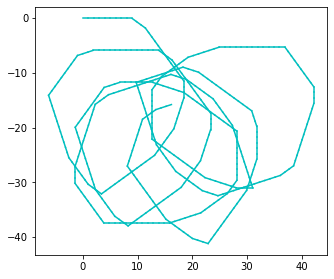

In [20]:
generator_GUI()